### Dataset Link


#### Yahoo Finance https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset?select=symbols_valid_meta.csv

#### NEWS API https://newsapi.org/docs/client-libraries/python

### Import necessary packages for the project

In [1]:
import os
import glob

import time

import logging
import warnings

import asyncio
import nest_asyncio

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.preprocessing import MinMaxScaler

import dask.dataframe as dd
from dask import delayed, compute
from dask.distributed import Client, SchedulerPlugin

from dask_jobqueue import SLURMCluster
from dask.distributed import LocalCluster

from threading import Thread

import torch
import torch.nn as nn

import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import Dataset, DataLoader, DistributedSampler

### Defining Logger Functionality

In [2]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("ScalingLogger")

nest_asyncio.apply()

In [3]:
# Custom Plugin to log scaling events
class ScalingLogger(SchedulerPlugin):
    def __init__(self, logger):
        self.logger = logger

    def add_worker(self, scheduler=None, worker=None, **kwargs):
        self.logger.info(f"Worker added: {worker}")

    def remove_worker(self, scheduler=None, worker=None, **kwargs):
        self.logger.info(f"Worker removed: {worker}")

In [4]:
# Define a callback to log scaling events
def log_scaling_event(scheduler_info):
    n_workers = len(scheduler_info['workers'])
    logger.info(f"Cluster scaled. Current number of workers: {n_workers}")

### Set the working directory and dataset path

In [5]:
working_directory = '/home/rajagopalmohanraj.n/HPC/final_project/'
datasets = working_directory + 'datasets/'

### Get CSV

In [6]:
def get_csv():
    
    """
    Read all CSV files from the 'stocks' folder, add a Stock Symbol column,
    and return a Dask DataFrame.
    """
    
    # Reading all CSV files and adding Stock Symbol
    stock_df = dd.read_csv(
        f'{datasets}stocks/*.csv',
        blocksize='16MB',
        dtype={
            'Date': 'str',
            'Open': 'float64',
            'High': 'float64',
            'Low': 'float64',
            'Close': 'float64',
            'Volume': 'float64'
        },
        include_path_column='source_file'  # Adds filename as a column
    )
    
    # Extracting stock symbol from filename
    stock_df['Symbol'] = stock_df['source_file'].map_partitions(
        lambda x: x.str.extract(r'([A-Z]+)\.csv$')[0]
    )
    
    # Dropping the source_file column
    stock_df = stock_df.drop('source_file', axis=1)
    stock_df = stock_df.repartition(npartitions=200)
    stock_df = stock_df.persist()
    return stock_df

### Function to Pre-process the Data

In [7]:
def preprocess_function(df):
    
    """
    Preprocess the input DataFrame by adding features and handling NaN values.

    Args:
        df (Dask.DataFrame): The input DataFrame containing stock data.

    Returns:
        pd.DataFrame: The preprocessed DataFrame with additional features.
    """
    
    # Converting 'Date' to datetime
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    
    # Dropping rows with any NaN values in important columns
    df = df.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])
    
    # Creating additional features
    df['Returns'] = df['Close'].pct_change()  # Daily returns
    df['MA_20'] = df['Close'].rolling(window=20).mean().shift(1)  # 20-day moving average
    df['Volatility'] = df['Returns'].rolling(window=20).std().shift(1)  # 20-day volatility
    
    # Dropping NaN values created by shifting
    df = df.dropna(subset=['MA_20', 'Volatility'])
    
    return df


### Preparing the Dataset

In [8]:
class StockDataset(Dataset):
    
    """
    A PyTorch Dataset for stock data.

    Args:
        df (Dask.DataFrame): The input DataFrame containing stock data.
        sequence_length (int): The length of each sequence in the dataset.
    """
    
    def __init__(self, df, sequence_length=60):
        self.sequences = []
        self.targets = []
        
        for symbol in df['Symbol'].unique():
            stock_data = df[df['Symbol'] == symbol].sort_values('Date')
            
            # Make sure to include all 8 features as defined in the model
            features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'MA_20', 'Volatility']
            data = stock_data[features].values
            
            # Normalize data
            scaler = MinMaxScaler()
            scaled_data = scaler.fit_transform(data)
            
            for i in range(len(scaled_data) - sequence_length):
                self.sequences.append(scaled_data[i:(i + sequence_length)])
                self.targets.append(scaled_data[i + sequence_length, 3])  # Close price index
        
        # Convert to numpy array first, then to tensor
        self.sequences = torch.FloatTensor(np.array(self.sequences))
        self.targets = torch.FloatTensor(np.array(self.targets)).reshape(-1, 1)
    
    def __len__(self):
        """Return the total number of sequences in the dataset."""
        return len(self.sequences)
    
    def __getitem__(self, idx):
        """Return a single sequence and its corresponding target."""
        return self.sequences[idx], self.targets[idx]

### GRU Implementation

In [9]:
class StockGRU(nn.Module):
    """
    Gated Recurrent Unit (GRU) model for stock price prediction.

    This class implements a GRU network followed by fully connected layers
    to predict stock prices based on sequential input data.

    Args:
        input_size (int): Number of input features. Default is 8.
        hidden_size (int): Number of features in the hidden state. Default is 128.
        num_layers (int): Number of GRU layers. Default is 2.
        dropout (float): Dropout rate to use between GRU layers and in the fully connected layer. Default is 0.2.

    Attributes:
        gru (nn.GRU): The GRU layer(s) of the model.
        fc (nn.Sequential): The fully connected layers for final prediction.
    """
    def __init__(self, input_size=8, hidden_size=128, num_layers=2, dropout=0.2):
        super(StockGRU, self).__init__()
        
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        """
        Forward pass of the StockGRU model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, input_size).

        Returns:
            torch.Tensor: Output predictions of shape (batch_size, 1).
        """
        gru_out, _ = self.gru(x)
        predictions = self.fc(gru_out[:, -1, :])
        return predictions

### Setting up a Distributed Trainer

In [10]:
class DistributedTrainer:
    """
    Trainer class for distributed training of the StockRNN model.

    Args:
        model (nn.Module): The StockRNN model to train.
        train_data (Dataset): Training dataset.
        val_data (Dataset): Validation dataset.
        test_data (Dataset): Test dataset.
    """
    def __init__(self, model, train_data, val_data, test_data):
        self.local_rank = int(os.environ.get("LOCAL_RANK", 0))
        self.world_size = int(os.environ.get("WORLD_SIZE", 1))
        
        # Initialize process group
        if self.world_size > 1:
            dist.init_process_group(backend='gloo')
        
        # Prepare model for DDP
        self.model = DDP(model) if self.world_size > 1 else model
        
        # Create data loaders with DistributedSampler
        self.train_loader = self._prepare_dataloader(train_data, shuffle=True)
        self.val_loader = self._prepare_dataloader(val_data, shuffle=False)
        self.test_loader = self._prepare_dataloader(test_data, shuffle=False)
        
        # Loss and optimizer
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.1, patience=5
        )
    
    def _prepare_dataloader(self, dataset, shuffle):
        """
        Prepare a DataLoader for the given dataset.

        Args:
            dataset (Dataset): The dataset to create a DataLoader for.
            shuffle (bool): Whether to shuffle the data.

        Returns:
            DataLoader: The prepared DataLoader.
        """
        sampler = DistributedSampler(dataset) if self.world_size > 1 else None
        return DataLoader(
            dataset,
            batch_size=32,
            shuffle=(shuffle and sampler is None),
            sampler=sampler,
            num_workers=4,
            pin_memory=True
        )
    
    def train(self, epochs):
        """
        Train the model for the specified number of epochs.

        Args:
            epochs (int): Number of epochs to train for.
        """
        for epoch in range(epochs):
            if self.world_size > 1:
                self.train_loader.sampler.set_epoch(epoch)

            # Training phase
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0

            for batch_idx, (data, target) in enumerate(self.train_loader):
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()

                # Calculate accuracy
                predicted = torch.abs(output - target) < 0.05  # 5% threshold for stock prediction
                train_correct += predicted.sum().item()
                train_total += target.size(0)

            # Validation phase
            val_loss, val_accuracy = self.validate()

            # Update learning rate
            self.scheduler.step(val_loss)

            print(f'Epoch {epoch}: '
                  f'Train Loss: {train_loss/len(self.train_loader):.5f}, '
                  f'Train Acc: {100.*train_correct/train_total:.2f}%, '
                  f'Val Loss: {val_loss:.5f}, '
                  f'Val Acc: {val_accuracy:.2f}%')

    def validate(self):
        """
        Validate the model on the validation set.

        Returns:
            tuple: A tuple containing the validation loss and accuracy.
        """
        self.model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in self.val_loader:
                output = self.model(data)
                val_loss += self.criterion(output, target).item()

                # Calculate accuracy
                predicted = torch.abs(output - target) < 0.05  # 5% threshold
                correct += predicted.sum().item()
                total += target.size(0)

        return val_loss / len(self.val_loader), 100. * correct / total
    
    def test(self):
        """
        Test the model on the test set.

        Returns:
            tuple: A tuple containing arrays of predictions and actual values.
        """
        self.model.eval()
        predictions = []
        actuals = []

        with torch.no_grad():
            try:
                for data, target in self.test_loader:
                    # Ensure correct shape and handle device properly
                    output = self.model(data).squeeze().cpu().numpy()
                    predictions.extend(output)
                    actuals.extend(target.cpu().numpy())

            except Exception as e:
                print(f"Error during testing: {e}")

        return np.array(predictions), np.array(actuals)


### Main Function

In [11]:
def main(popular_stocks):
    df = get_csv()
    stock_df = df[df['Symbol'].isin(popular_stocks)]
    processed_df = stock_df.map_partitions(preprocess_function).compute()
    
    # Prepare datasets
    full_dataset = StockDataset(processed_df)
    
    # Split datasets
    train_size = int(0.7 * len(full_dataset))
    val_size = int(0.15 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, val_size, test_size]
    )
    
    # Initialize GRU model
    model = StockGRU(input_size=8)  # 8 features as defined in StockDataset
    trainer = DistributedTrainer(model, train_dataset, val_dataset, test_dataset)
    
    # Train model
    trainer.train(epochs=10)
    
    # Test model
    predictions, actuals = trainer.test()
    
    # Cleanup
    if dist.is_initialized():
        dist.destroy_process_group()
    
    cluster.close()
    client.close()
    
    return predictions, actuals

### Plot Results Comparision

In [12]:
def plot_results(results):
    """
    Plot the results of different SLURM configurations.

    Args:
        results (dict): Dictionary containing results for each configuration.
    """
    # Convert nested dictionary to DataFrame
    df = pd.DataFrame({
        'Configuration': list(results.keys()),
        'Execution Time': [results[k]['execution_time'] for k in results],
        'Cores': [results[k]['configuration']['cores'] for k in results],
        'Memory': [results[k]['configuration']['memory'] for k in results],
        'Processes': [results[k]['configuration']['processes'] for k in results],
        'Scaling Jobs': [results[k]['scaling_jobs'] for k in results]
    })

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Bar plot
    sns.barplot(data=df, x='Configuration', y='Execution Time', hue='Configuration',
                palette='Blues', ax=ax1)
    ax1.set_title('Execution Time Comparison Across Configurations')
    ax1.set_ylabel('Execution Time (seconds)')
    ax1.grid(axis='y')

    # Line plot for scaling performance
    ax2.plot(df['Configuration'], df['Execution Time'], 
             marker='o', color='orange', linewidth=2)
    ax2.set_title('Scaling Performance Across Configurations')
    ax2.set_ylabel('Execution Time (seconds)')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Resource allocation visualization
    plt.figure(figsize=(10, 6))
    width = 0.2
    x = range(len(df['Configuration']))

    plt.bar(x, df['Cores'], width, label='Cores')
    plt.bar([i + width for i in x], df['Processes'], width, label='Processes')
    plt.bar([i + width*2 for i in x], df['Scaling Jobs'], width, label='Scaling Jobs')

    plt.xlabel('Configuration')
    plt.ylabel('Count')
    plt.title('Resource Allocation Across Configurations')
    plt.xticks([i + width for i in x], df['Configuration'])
    plt.legend()
    plt.grid(axis='y')
    plt.show()

### Calculating Speedup

In [13]:
def calculate_speedup(results):
    """
    Calculate speedup and efficiency metrics for different configurations.

    Args:
        results (dict): Dictionary containing results for each configuration.

    Returns:
        dict: Dictionary containing speedup metrics for each configuration.
    """
    # Get baseline (small configuration) time
    baseline_time = results['small']['execution_time']
    
    speedup_metrics = {}
    for config, data in results.items():
        speedup = baseline_time / data['execution_time']
        efficiency = speedup / data['configuration']['processes']  # Parallel efficiency
        
        speedup_metrics[config] = {
            'execution_time': data['execution_time'],
            'speedup': speedup,
            'efficiency': efficiency,
            'cores': data['configuration']['cores'],
            'processes': data['configuration']['processes']
        }
    
    return speedup_metrics

### Visualizing Speedup and Efficiency

In [14]:
# Visualize speedup and efficiency
def plot_speedup_metrics(speedup_metrics):
    """
    Visualize speedup and efficiency metrics.

    Args:
        speedup_metrics (dict): Dictionary containing speedup metrics for each configuration.
    """
    configs = list(speedup_metrics.keys())
    speedups = [metrics['speedup'] for metrics in speedup_metrics.values()]
    efficiencies = [metrics['efficiency'] for metrics in speedup_metrics.values()]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Speedup plot
    ax1.plot(configs, speedups, marker='o', linewidth=2)
    ax1.set_title('Speedup vs Configuration')
    ax1.set_ylabel('Speedup (T1/Tn)')
    ax1.grid(True)
    
    # Efficiency plot
    ax2.plot(configs, efficiencies, marker='s', linewidth=2, color='orange')
    ax2.set_title('Parallel Efficiency vs Configuration')
    ax2.set_ylabel('Efficiency (Speedup/N)')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Create summary table
    summary_df = pd.DataFrame(speedup_metrics).T
    print("\nSpeedup Analysis Summary:")
    print(summary_df.round(3))

### Plot Speedup and Efficiency

In [15]:
def plot_speedup_efficiency(results):
    """
    Plot speedup and efficiency on the same graph for different configurations.

    Args:
        results (dict): Dictionary containing results for each configuration.
    """
    # Calculate speedup and efficiency
    baseline_time = results['small']['execution_time']
    speedup = {k: baseline_time / v['execution_time'] for k, v in results.items()}
    efficiency = {k: speedup[k] / v['configuration']['processes'] 
                 for k, v in results.items()}
    
    # Prepare data
    configurations = list(results.keys())
    speedup_values = list(speedup.values())
    efficiency_values = list(efficiency.values())
    
    # Create figure and axis
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot speedup (left y-axis)
    ax1.set_xlabel('Configuration')
    ax1.set_ylabel('Speedup (T1/Tn)', color='blue')
    line1 = ax1.plot(configurations, speedup_values, 'blue', 
                     marker='o', label='Speedup')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Create second y-axis for efficiency
    ax2 = ax1.twinx()
    ax2.set_ylabel('Efficiency (Speedup/N)', color='orange')
    line2 = ax2.plot(configurations, efficiency_values, 'orange', 
                     marker='s', label='Efficiency')
    ax2.tick_params(axis='y', labelcolor='orange')
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='center right')
    
    plt.title('Speedup and Efficiency vs Configuration')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print numerical results
    print("\nNumerical Results:")
    for config in configurations:
        print(f"{config:>8}: Speedup = {speedup[config]:.2f}, "
              f"Efficiency = {efficiency[config]:.2f}")

In [16]:
%%time
# Define configurations without n_jobs parameter
slurm_configs = {
    'small': {
        'cores': 1,
        'memory': '16GB',
        'processes': 1,
        'min_workers': 1,
        'max_workers': 1
    },
    'medium': {
        'cores': 12,
        'memory': '32GB',
        'processes': 6,
        'min_workers': 8,
        'max_workers': 20
    },
    'large': {
        'cores': 12,
        'memory': '32GB',
        'processes': 8,
        'min_workers': 20,
        'max_workers': 30
    }
}

popular_stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']
results = {}

for config_name, params in slurm_configs.items():
    print(f"\nTesting SLURM {config_name} configuration:")
    start_time = time.time()
    
    
    try:
        
        world_size = params['cores'] * params['processes'] * params['max_workers']
        job_script_prologue = [
            'export MASTER_ADDR=$(hostname)',
            'export MASTER_PORT=29500',
            f'export WORLD_SIZE={world_size}',
            'export LOCAL_RANK=${SLURM_LOCALID}',
            f'export RANK=$((SLURM_NODEID * {params["processes"]} + SLURM_LOCALID))'
        ]
        
        # Create cluster with remaining parameters
        cluster = SLURMCluster(
            queue='courses',
            walltime='01:00:00',
            death_timeout=60,
            nanny=True,
            cores=params['cores'],
            memory=params['memory'],
            processes=params['processes'],
            job_script_prologue=job_script_prologue,
            worker_extra_args=["--lifetime", "55m", "--lifetime-stagger", "4m"],
        )
        
        
        cluster.adapt(minimum=params['min_workers'], maximum=params['max_workers'])
        
        # Create client and run computation
        with Client(cluster) as client:
            display(HTML(f"<a href='{client.dashboard_link}'>Dask Dashboard</a>"))
            print(f"Dashboard link: {client.dashboard_link}")
            print(f"Cluster status: {client.status}")
            
            scaling_logger = ScalingLogger(logger)
            client.register_plugin(scaling_logger)
            
            predictions, actuals = main(popular_stocks)
            
            print("Main Function Done..!")
            
            execution_time = time.time() - start_time
            
            scheduler_info = client.scheduler_info()
            workers = scheduler_info.get('workers', {})
            
            results[config_name] = {
                'execution_time': execution_time,
                'configuration': params,
                'scaling_jobs': len(workers),
            }
            
            print(f"Configuration: {config_name}")
            print(f"Execution time: {execution_time:.2f} seconds")
            
            
            cluster.close()
            client.close()

            
    except Exception as e:
        print(f"Error with configuration {config_name}: {str(e)}")
        results[config_name] = {'error': str(e)}
        

# Print results summary
print("\nResults Summary:")
for config, result in results.items():
    if 'error' in result:
        print(f"{config}: Error - {result['error']}")
    else:
        print(f"{config}: {result['execution_time']:.2f} seconds")
        print(f"Configuration: {result['configuration']}")
        print(f"Scaling jobs: {result['scaling_jobs']}")
    print("-" * 50)


Testing SLURM small configuration:


Dashboard link: http://10.99.253.35:8787/status
Cluster status: running


INFO:ScalingLogger:Worker added: tcp://10.99.253.33:35673


Epoch 0: Train Loss: 0.00185, Train Acc: 88.79%, Val Loss: 0.00009, Val Acc: 99.71%
Epoch 1: Train Loss: 0.00081, Train Acc: 93.52%, Val Loss: 0.00050, Val Acc: 95.96%
Epoch 2: Train Loss: 0.00076, Train Acc: 94.21%, Val Loss: 0.00019, Val Acc: 99.02%
Epoch 3: Train Loss: 0.00068, Train Acc: 94.66%, Val Loss: 0.00016, Val Acc: 99.28%
Epoch 4: Train Loss: 0.00070, Train Acc: 94.76%, Val Loss: 0.00007, Val Acc: 99.62%
Epoch 5: Train Loss: 0.00066, Train Acc: 95.13%, Val Loss: 0.00016, Val Acc: 99.31%
Epoch 6: Train Loss: 0.00064, Train Acc: 95.21%, Val Loss: 0.00014, Val Acc: 98.92%
Epoch 7: Train Loss: 0.00064, Train Acc: 95.09%, Val Loss: 0.00021, Val Acc: 99.55%
Epoch 8: Train Loss: 0.00062, Train Acc: 95.29%, Val Loss: 0.00004, Val Acc: 99.81%
Epoch 9: Train Loss: 0.00066, Train Acc: 95.12%, Val Loss: 0.00006, Val Acc: 99.71%


INFO:ScalingLogger:Worker removed: tcp://10.99.253.33:35673
2024-12-01 23:59:07,913 - distributed.deploy.adaptive_core - INFO - Adaptive stop


Main Function Done..!
Configuration: small
Execution time: 734.48 seconds

Testing SLURM medium configuration:


Dashboard link: http://10.99.253.35:8787/status
Cluster status: running


INFO:ScalingLogger:Worker added: tcp://10.99.251.139:34862
INFO:ScalingLogger:Worker added: tcp://10.99.251.139:33047
INFO:ScalingLogger:Worker added: tcp://10.99.251.139:38290
INFO:ScalingLogger:Worker added: tcp://10.99.251.139:40440
INFO:ScalingLogger:Worker added: tcp://10.99.251.139:39535
INFO:ScalingLogger:Worker added: tcp://10.99.251.139:33532
INFO:ScalingLogger:Worker added: tcp://10.99.253.33:38334
INFO:ScalingLogger:Worker added: tcp://10.99.253.33:41198
INFO:ScalingLogger:Worker added: tcp://10.99.253.33:45195
INFO:ScalingLogger:Worker added: tcp://10.99.253.33:36825
INFO:ScalingLogger:Worker added: tcp://10.99.253.33:35271
INFO:ScalingLogger:Worker added: tcp://10.99.253.33:42698
INFO:ScalingLogger:Worker removed: tcp://10.99.253.33:36825
INFO:ScalingLogger:Worker removed: tcp://10.99.253.33:41198
INFO:ScalingLogger:Worker removed: tcp://10.99.253.33:35271
INFO:ScalingLogger:Worker removed: tcp://10.99.253.33:38334
INFO:ScalingLogger:Worker removed: tcp://10.99.253.33:4269

Epoch 0: Train Loss: 0.00206, Train Acc: 87.70%, Val Loss: 0.00012, Val Acc: 99.40%
Epoch 1: Train Loss: 0.00105, Train Acc: 92.08%, Val Loss: 0.00019, Val Acc: 99.11%
Epoch 2: Train Loss: 0.00082, Train Acc: 93.45%, Val Loss: 0.00016, Val Acc: 99.07%
Epoch 3: Train Loss: 0.00082, Train Acc: 93.75%, Val Loss: 0.00013, Val Acc: 99.23%
Epoch 4: Train Loss: 0.00075, Train Acc: 94.44%, Val Loss: 0.00010, Val Acc: 99.71%
Epoch 5: Train Loss: 0.00074, Train Acc: 94.50%, Val Loss: 0.00027, Val Acc: 97.73%
Epoch 6: Train Loss: 0.00072, Train Acc: 94.45%, Val Loss: 0.00011, Val Acc: 99.78%
Epoch 7: Train Loss: 0.00072, Train Acc: 94.56%, Val Loss: 0.00031, Val Acc: 95.98%
Epoch 8: Train Loss: 0.00069, Train Acc: 94.74%, Val Loss: 0.00005, Val Acc: 99.78%
Epoch 9: Train Loss: 0.00067, Train Acc: 94.87%, Val Loss: 0.00007, Val Acc: 99.74%


INFO:ScalingLogger:Worker removed: tcp://10.99.251.139:34862
INFO:ScalingLogger:Worker removed: tcp://10.99.251.139:33047
INFO:ScalingLogger:Worker removed: tcp://10.99.251.139:38290
INFO:ScalingLogger:Worker removed: tcp://10.99.251.139:40440
INFO:ScalingLogger:Worker removed: tcp://10.99.251.139:39535
INFO:ScalingLogger:Worker removed: tcp://10.99.251.139:33532
2024-12-02 00:08:24,139 - distributed.deploy.adaptive_core - INFO - Adaptive stop


Main Function Done..!
Configuration: medium
Execution time: 556.22 seconds

Testing SLURM large configuration:


Dashboard link: http://10.99.253.35:8787/status
Cluster status: running


INFO:ScalingLogger:Worker added: tcp://10.99.251.139:41458
INFO:ScalingLogger:Worker added: tcp://10.99.251.139:42094
INFO:ScalingLogger:Worker added: tcp://10.99.251.139:42510
INFO:ScalingLogger:Worker added: tcp://10.99.251.139:33182
INFO:ScalingLogger:Worker added: tcp://10.99.251.139:38130
INFO:ScalingLogger:Worker added: tcp://10.99.251.139:46677
INFO:ScalingLogger:Worker added: tcp://10.99.251.139:44448
INFO:ScalingLogger:Worker added: tcp://10.99.251.139:33205
INFO:ScalingLogger:Worker added: tcp://10.99.253.39:45478
INFO:ScalingLogger:Worker added: tcp://10.99.253.39:46301
INFO:ScalingLogger:Worker added: tcp://10.99.253.39:37048
INFO:ScalingLogger:Worker added: tcp://10.99.253.39:36050
INFO:ScalingLogger:Worker added: tcp://10.99.253.39:35783
INFO:ScalingLogger:Worker added: tcp://10.99.253.39:46084
INFO:ScalingLogger:Worker added: tcp://10.99.253.39:41913
INFO:ScalingLogger:Worker added: tcp://10.99.253.39:38655


Epoch 0: Train Loss: 0.00282, Train Acc: 85.21%, Val Loss: 0.00027, Val Acc: 97.01%
Epoch 1: Train Loss: 0.00109, Train Acc: 91.34%, Val Loss: 0.00016, Val Acc: 98.92%
Epoch 2: Train Loss: 0.00081, Train Acc: 93.06%, Val Loss: 0.00030, Val Acc: 99.57%
Epoch 3: Train Loss: 0.00074, Train Acc: 93.98%, Val Loss: 0.00005, Val Acc: 99.86%
Epoch 4: Train Loss: 0.00067, Train Acc: 94.45%, Val Loss: 0.00025, Val Acc: 98.11%
Epoch 5: Train Loss: 0.00069, Train Acc: 94.68%, Val Loss: 0.00031, Val Acc: 97.32%
Epoch 6: Train Loss: 0.00064, Train Acc: 94.83%, Val Loss: 0.00009, Val Acc: 99.38%
Epoch 7: Train Loss: 0.00068, Train Acc: 95.08%, Val Loss: 0.00005, Val Acc: 99.83%
Epoch 8: Train Loss: 0.00063, Train Acc: 95.22%, Val Loss: 0.00022, Val Acc: 98.30%
Epoch 9: Train Loss: 0.00064, Train Acc: 95.35%, Val Loss: 0.00007, Val Acc: 99.74%


INFO:ScalingLogger:Worker removed: tcp://10.99.251.139:41458
INFO:ScalingLogger:Worker removed: tcp://10.99.251.139:42094
INFO:ScalingLogger:Worker removed: tcp://10.99.251.139:42510
INFO:ScalingLogger:Worker removed: tcp://10.99.251.139:33182
INFO:ScalingLogger:Worker removed: tcp://10.99.251.139:38130
INFO:ScalingLogger:Worker removed: tcp://10.99.251.139:46677
INFO:ScalingLogger:Worker removed: tcp://10.99.251.139:44448
INFO:ScalingLogger:Worker removed: tcp://10.99.251.139:33205
INFO:ScalingLogger:Worker removed: tcp://10.99.253.39:45478
INFO:ScalingLogger:Worker removed: tcp://10.99.253.39:46301
INFO:ScalingLogger:Worker removed: tcp://10.99.253.39:37048
INFO:ScalingLogger:Worker removed: tcp://10.99.253.39:36050
INFO:ScalingLogger:Worker removed: tcp://10.99.253.39:35783
INFO:ScalingLogger:Worker removed: tcp://10.99.253.39:46084
INFO:ScalingLogger:Worker removed: tcp://10.99.253.39:41913
INFO:ScalingLogger:Worker removed: tcp://10.99.253.39:38655
2024-12-02 00:17:10,130 - distri

Main Function Done..!
Configuration: large
Execution time: 526.00 seconds

Results Summary:
small: 734.48 seconds
Configuration: {'cores': 1, 'memory': '16GB', 'processes': 1, 'min_workers': 1, 'max_workers': 1}
Scaling jobs: 0
--------------------------------------------------
medium: 556.22 seconds
Configuration: {'cores': 12, 'memory': '32GB', 'processes': 6, 'min_workers': 8, 'max_workers': 20}
Scaling jobs: 0
--------------------------------------------------
large: 526.00 seconds
Configuration: {'cores': 12, 'memory': '32GB', 'processes': 8, 'min_workers': 20, 'max_workers': 30}
Scaling jobs: 0
--------------------------------------------------
CPU times: user 5h 47min 5s, sys: 34min 56s, total: 6h 22min 2s
Wall time: 30min 16s


In [17]:
results

{'small': {'execution_time': 734.4849045276642,
  'configuration': {'cores': 1,
   'memory': '16GB',
   'processes': 1,
   'min_workers': 1,
   'max_workers': 1},
  'scaling_jobs': 0},
 'medium': {'execution_time': 556.2189607620239,
  'configuration': {'cores': 12,
   'memory': '32GB',
   'processes': 6,
   'min_workers': 8,
   'max_workers': 20},
  'scaling_jobs': 0},
 'large': {'execution_time': 525.99693775177,
  'configuration': {'cores': 12,
   'memory': '32GB',
   'processes': 8,
   'min_workers': 20,
   'max_workers': 30},
  'scaling_jobs': 0}}

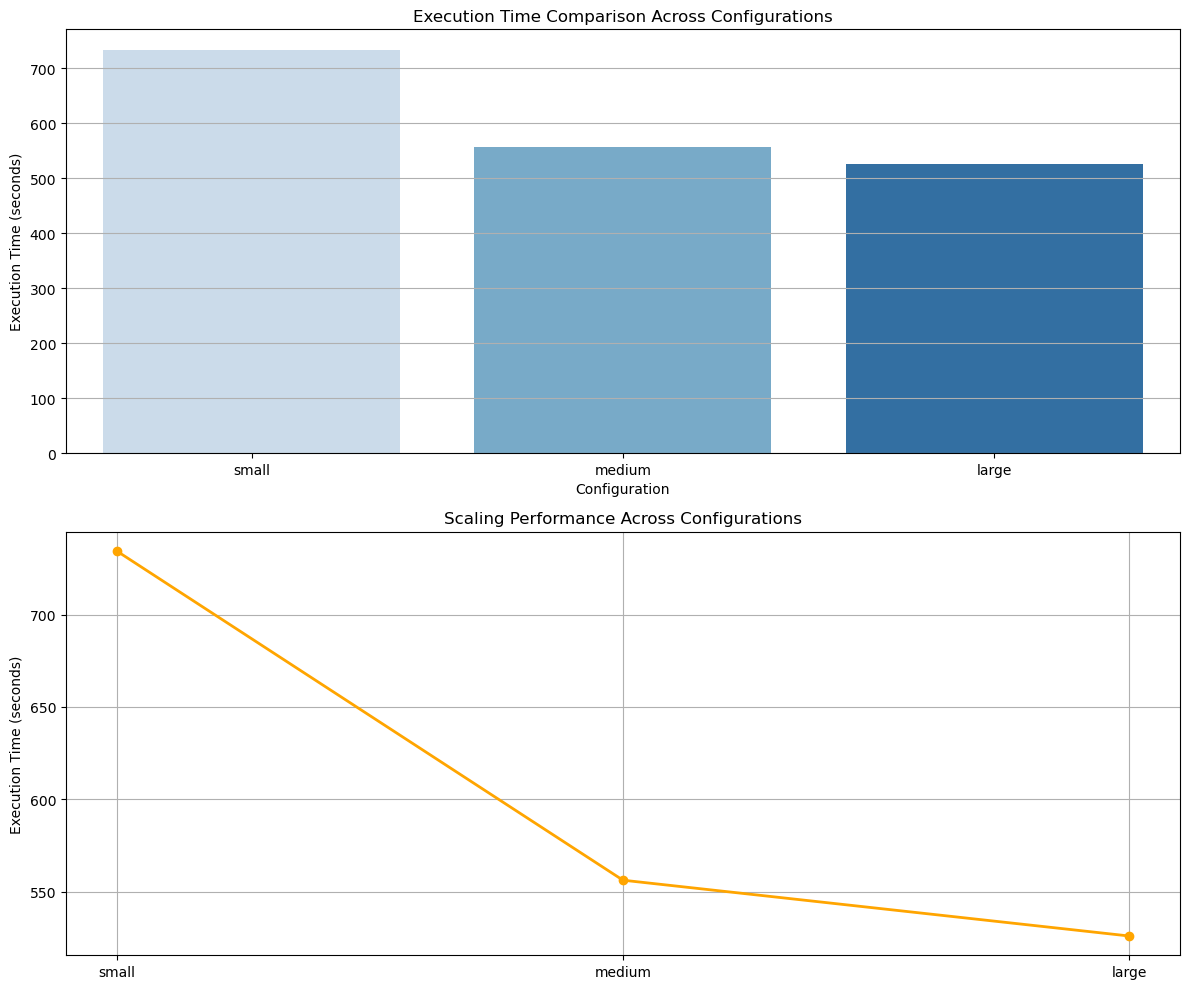

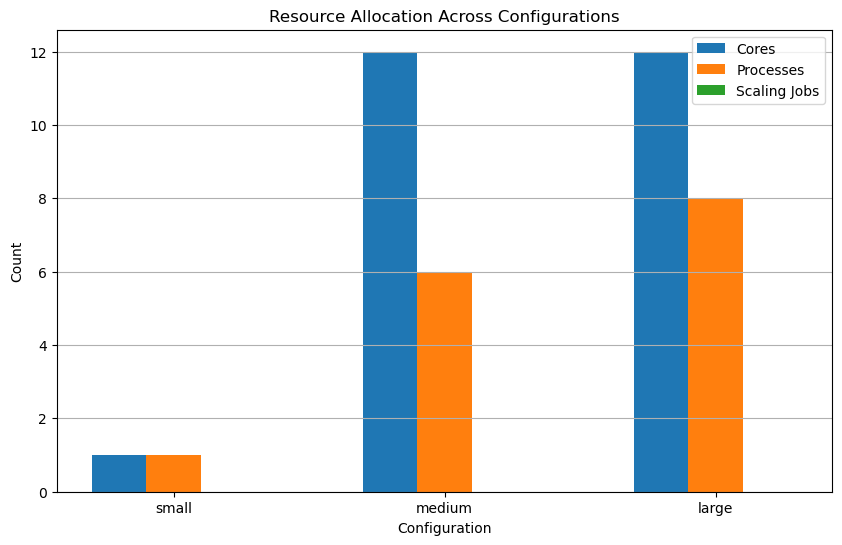

In [18]:
plot_results(results)

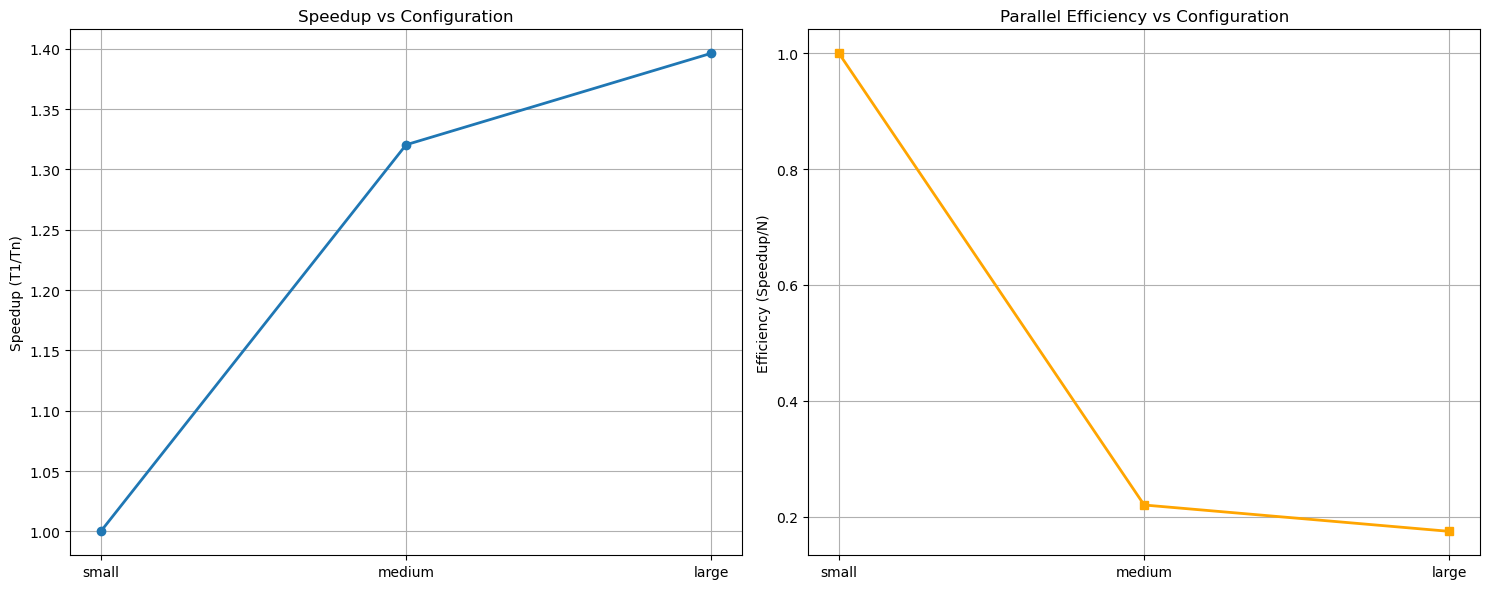


Speedup Analysis Summary:
        execution_time  speedup  efficiency  cores  processes
small          734.485    1.000       1.000    1.0        1.0
medium         556.219    1.320       0.220   12.0        6.0
large          525.997    1.396       0.175   12.0        8.0


In [19]:
speedup_metrics = calculate_speedup(results)
plot_speedup_metrics(speedup_metrics)

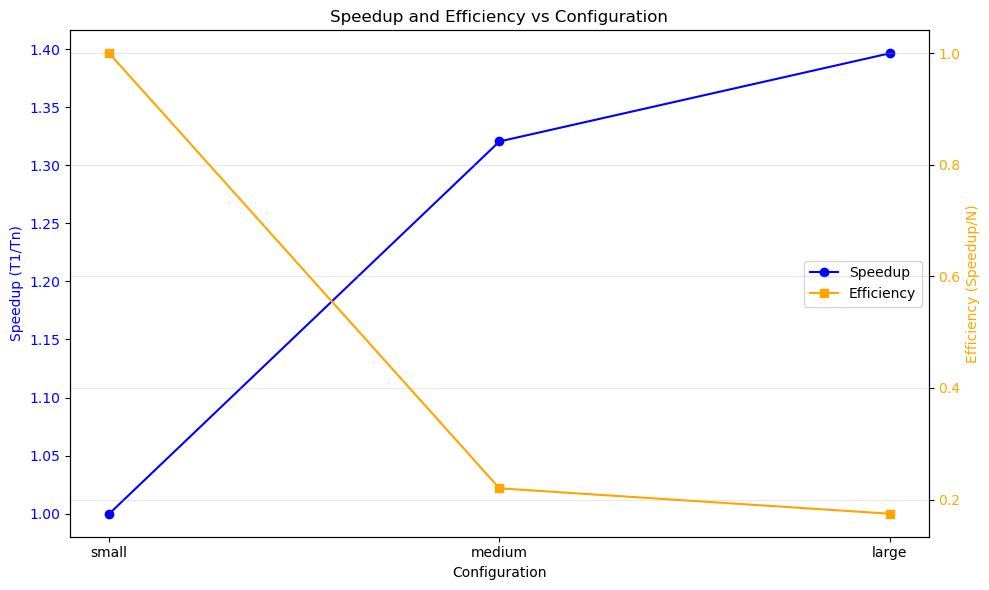


Numerical Results:
   small: Speedup = 1.00, Efficiency = 1.00
  medium: Speedup = 1.32, Efficiency = 0.22
   large: Speedup = 1.40, Efficiency = 0.17


In [20]:
plot_speedup_efficiency(results)

In [21]:
plot_df = pd.DataFrame({
    'Configuration': list(results.keys()),
    'Cores': [results[k]['configuration']['cores'] for k in results],
    'Memory': [results[k]['configuration']['memory'] for k in results],
    'Processes': [results[k]['configuration']['processes'] for k in results],
    'Scaling Jobs': [results[k]['scaling_jobs'] for k in results]
})
plot_df

,Configuration,Cores,Memory,Processes,Scaling Jobs
0,small,1,16GB,1,0
1,medium,12,32GB,6,0
2,large,12,32GB,8,0
